# Load Data

In [3]:
from fastai.vision.all import *
from fastai.vision.widgets import *

import pandas as pd

In [2]:
#!pip install fastai_xla_extensions

In [9]:
#from fastai_xla_extensions.all import *

Add [birds species](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) data set to Notebook. An easy way to do this is to navigate to the data set and click **New Notebook** button at top-right.

Set path to data set location.

In [5]:
path = Path('/kaggle/input/100-bird-species')

[Folder structure](https://github.com/himalayahall/YU_FASTAI/blob/e1cb5b2c271a51bcaf416985a99bf5c5aae567ba/Kaggle-Birds-450-Species-Screenshot.jpg) shows data is laid out in train/test/valid folders. In addition, the **birds.csv** file provides a comprehensive listing of all bird images along with their categories and train/test/valid partition.

Within train/test/valid folders are multiple folders, one per species, containing images. 

This provides us a few different strategies available for data loading:

1. Use birds.csv to load data
2. Use folder structure to load data

Data sets are frequently provided in one of these two formats (if one is lucky!). We will use the first data loading strategy.

We will load **birds.csv** into a Pandas dataframe. 

In [6]:
df = pd.read_csv(path/'birds.csv')

Examine data.

In [7]:
df.head()

,class id,filepaths,labels,scientific label,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,Malacocincla abbotti,train


# Build DataBlock

For image classification in fast.ai, we have to provide functions for getting the predictor variable (x) and the class label (y). The parameter to both functions will be a **pandas series** with one data frame row. 

For the predictor variable, **get_x** will return the full path of the image file: **path/filepaths**. 

For the class label, variable, **get_y** returns the **labels**. 

In [8]:
def get_x(r) : return path/r.filepaths
def get_y(r) : return r.labels

Let's create a simple **DataBlock** to verify our strategy works as expected.

In [9]:
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/kaggle/input/100-bird-species/train/CHESTNET BELLIED EUPHONIA/098.jpg'),
 'CHESTNET BELLIED EUPHONIA')

In [ ]:
# import warnings
# try:
#     import torch_xla
# except ImportError as e:
#     warnings.warn('TPU environment not available')

Next, we create a custom **splitter** function to separate the dataframe into train/valid partitions and return the partition indices as lists.

In [10]:
# def splitter(df):
#     train = df.index[df['data set'] == 'train'].tolist() 
#     valid = df.index[df['data set'] == 'valid'].tolist() 
#     return train,valid

In [ ]:
# dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
#             splitter = splitter,
#             get_y = get_y,
#             get_x = get_x,
#             item_tfms=[Resize(220, method='squish')],
#             batch_tfms=aug_transforms()
#                   )
# dls = dblock.dataloaders(df)
# dls.show_batch(max_n=9, nrows=3)

The most efficient way (to avoid iterating over the rows of the dataframe, which can take a long time) is to use the from_columns method. It will use get_items to convert the columns into numpy arrays. 

The drawback is that since we lose the dataframe after extracting the relevant columns, we can’t use a ColSplitter anymore. 

Here we used an IndexSplitter after manually extracting the index of the validation set from the dataframe:

In [27]:
def _bird_items(x): 
    return (f'{path}/'+x.filepaths, x.labels)

valid_idx = df.index[df['data set'] == 'valid'].values

The way we usually build the data block in one go is by answering a list of questions:

- what is the types of your inputs/targets? Here images and categories

- where is your data? Here in data frame columns (labels and image file names) and in folders (image files)

- does something need to be applied to inputs? Here the get_x function

- does something need to be applied to the target? Here the get_y function

- how to split the data? Here the splitter function

- do we need to apply something on formed items? Here a resize (necessary for processing tensors on GPUs) 

- do we need to apply something on formed batches? Here augmentation transforms


In [28]:
dblock = DataBlock.from_columns(blocks=(ImageBlock, CategoryBlock),
            splitter = IndexSplitter(valid_idx),
            get_items = _bird_items,
            item_tfms=[Resize(220, method='squish')],
            batch_tfms=aug_transforms()
            )
dls = dblock.dataloaders(df)

Let's verify that dataloader was created successfully.

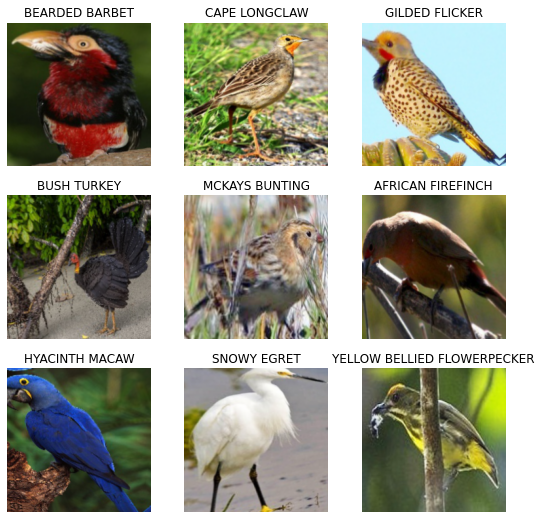

In [30]:
dls.show_batch(max_n=9, nrows=3)

# Build Learner

Now that dataloader was successfully created we can create our learner. Note: report **error_rate** and **accuracy** during training.

In [37]:
learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy])

Find the optimal learning rate for our image classification.

SuggestedLRs(valley=0.0020892962347716093)

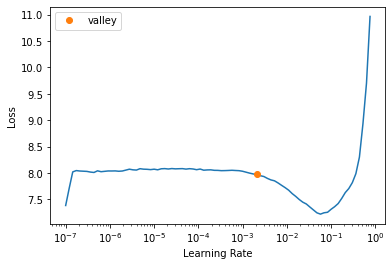

In [35]:
lr = learn.lr_find()
lr

In [41]:
base_lr=round(lr[0], 4)
base_lr

0.0021

Use the suggested LR to fine-tune model.

In [42]:
learn.fine_tune(3, base_lr=base_lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.413816,0.543397,0.148000,0.852000,05:00


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.787209,0.247043,0.066667,0.933333,05:15
1,0.552175,0.186085,0.053778,0.946222,05:14
2,0.325037,0.112484,0.032000,0.968000,05:14
3,0.249727,0.098408,0.026667,0.973333,05:14


Plot training/validation loss graph.

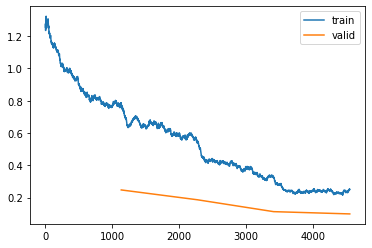

In [45]:
learn.recorder.plot_loss()

Show top losses.

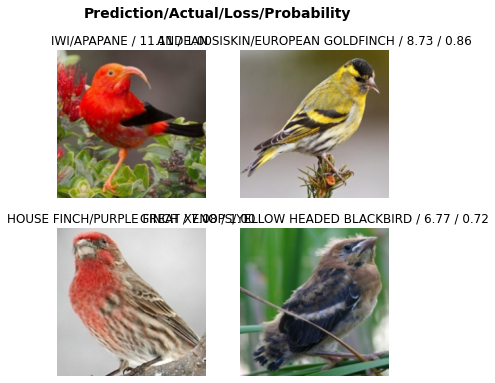

In [46]:
interp = ClassificationInterpretation.from_learner (learn)
interp.plot_top_losses(4, nrows=2)

In [ ]:
# We have 400 bird species and displaying 400x400 confusion matrix is a problem!
# interp.confusion_matrix()

In [47]:
interp.most_confused()

[('GILDED FLICKER', 'NORTHERN FLICKER', 4),
 ('PURPLE FINCH', 'HOUSE FINCH', 3),
 ('BREWERS BLACKBIRD', 'CROW', 2),
 ('DARWINS FLYCATCHER', 'VERMILION FLYCATHER', 2),
 ('FASCIATED WREN', 'CACTUS WREN', 2),
 ('TRICOLORED BLACKBIRD', 'RED WINGED BLACKBIRD', 2),
 ('ABBOTTS BOOBY', 'ALBATROSS', 1),
 ('AFRICAN PIED HORNBILL', 'BLUE MALKOHA', 1),
 ('AMERICAN PIPIT', 'ASHY THRUSHBIRD', 1),
 ('ANHINGA', 'DOUBLE BRESTED CORMARANT', 1),
 ('APAPANE', 'IWI', 1),
 ('ASHY STORM PETREL', 'GREY CUCKOOSHRIKE', 1),
 ('AUCKLAND SHAQ', 'BRANDT CORMARANT', 1),
 ('AVADAVAT', 'STRAWBERRY FINCH', 1),
 ('AZARAS SPINETAIL', 'FAN TAILED WIDOW', 1),
 ('CAPE MAY WARBLER', 'ANIANIAU', 1),
 ('CHINESE BAMBOO PARTRIDGE', 'MIKADO  PHEASANT', 1),
 ('CLARKS NUTCRACKER', 'GREY CUCKOOSHRIKE', 1),
 ('COMMON HOUSE MARTIN', 'GRAY KINGBIRD', 1),
 ('CRANE HAWK', 'NORTHERN GOSHAWK', 1),
 ('DARWINS FLYCATCHER', 'NORTHERN BEARDLESS TYRANNULET', 1),
 ('DEMOISELLE CRANE', 'BLUE HERON', 1),
 ('DOUBLE BRESTED CORMARANT', 'ANHINGA', 1)

In [ ]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Using the Model for Inference

Save trained model in 'birds.pkl'

In [48]:
learn.export(fname='birds.pkl')

Verify model was saved successfully.

In [49]:
curr_path = Path()
curr_path.ls(file_exts='.pkl')

(#1) [Path('birds.pkl')]

Load saved model.

In [50]:
learn_inf = load_learner(curr_path/'birds.pkl')

Use model to predict.

In [51]:
learn_inf.predict(path/'images to test'/'firefinch.jpg')

('AFRICAN FIREFINCH',
 TensorBase(5),
 TensorBase([1.8478e-06, 1.8091e-08, 1.0116e-06, 5.1928e-08, 3.9330e-09, 7.0186e-01,
         2.5818e-04, 7.0284e-11, 2.8144e-04, 2.5890e-04, 4.0058e-06, 3.4896e-06,
         2.2562e-07, 8.2763e-08, 4.2241e-09, 5.9370e-08, 1.9481e-03, 1.7007e-06,
         1.4528e-08, 7.9306e-08, 1.4238e-09, 2.1330e-09, 3.8839e-06, 1.7134e-07,
         9.2004e-07, 2.7246e-06, 4.1650e-09, 8.8180e-05, 5.6684e-04, 6.7888e-10,
         1.1482e-09, 9.4145e-04, 2.9892e-07, 1.6886e-07, 5.0445e-07, 1.4832e-07,
         1.1560e-03, 9.6505e-05, 7.7001e-10, 9.4886e-08, 1.1201e-08, 5.1491e-04,
         8.7653e-06, 7.9729e-09, 2.7148e-08, 2.6579e-06, 1.4473e-07, 5.9974e-08,
         3.1123e-07, 1.1580e-02, 5.8553e-10, 4.9980e-08, 1.2839e-08, 3.3762e-09,
         2.3702e-06, 7.0552e-08, 7.1744e-06, 3.9395e-06, 2.1667e-04, 9.9261e-07,
         4.8620e-07, 6.0426e-08, 5.8144e-08, 4.4741e-06, 1.0684e-07, 3.7712e-07,
         1.0419e-09, 3.0312e-08, 1.7001e-08, 2.9913e-09, 7.9047e-08

In [52]:
from fastai.vision.widgets import *

In [53]:
btn_upload = widgets.FileUpload()

In [54]:
out_pl = widgets.Output()

In [55]:
lbl_pred = widgets.Label()

In [56]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: 
        display(img.to_thumb(128,128))
        pred, pred_idx, probs = learn_inf.predict(img)
        lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [57]:
btn_run = widgets.Button(description='Classify')
btn_run.on_click(on_click_classify)

In [58]:
VBox([widgets.Label('Select your bird!'), btn_upload, btn_run, out_pl, lbl_pred])